Restaurant Tips Clustering Analysis 

Project: Customer Segmentation Based on Tipping Behavior


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
import os

In [23]:
# Configure display & style
sns.set_style("whitegrid")
pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = (8, 5)

In [24]:
print("Loading restaurant tips dataset...")
df = pd.read_csv('/Users/meghanas/Downloads/tip.csv')
print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
display(df.head())

Loading restaurant tips dataset...
 Dataset loaded: 244 rows, 7 columns


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [25]:
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 13.5+ KB


In [26]:
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64


In [27]:
num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(exclude=[np.number]).columns

print(f"\nNumerical Columns: {list(num_cols)}")
print(f"Categorical Columns: {list(cat_cols)}")


Numerical Columns: ['total_bill', 'tip', 'size']
Categorical Columns: ['sex', 'smoker', 'day', 'time']


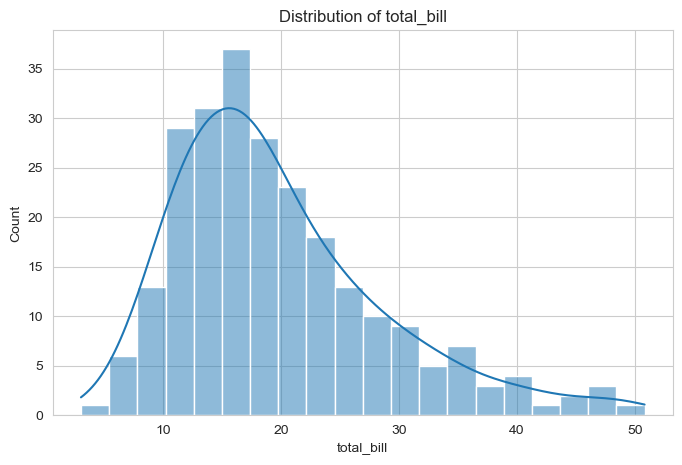

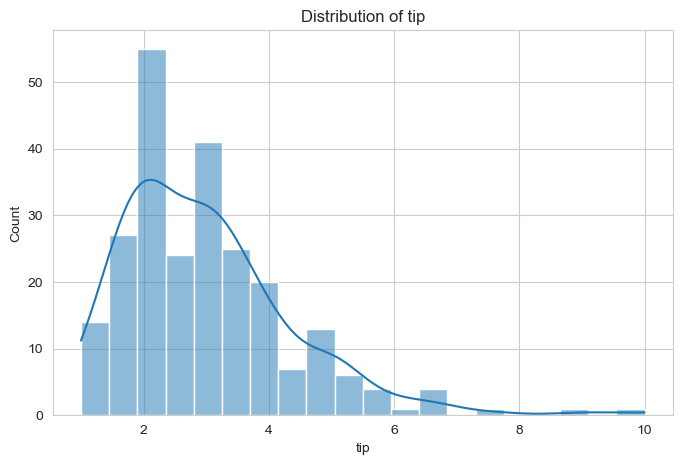

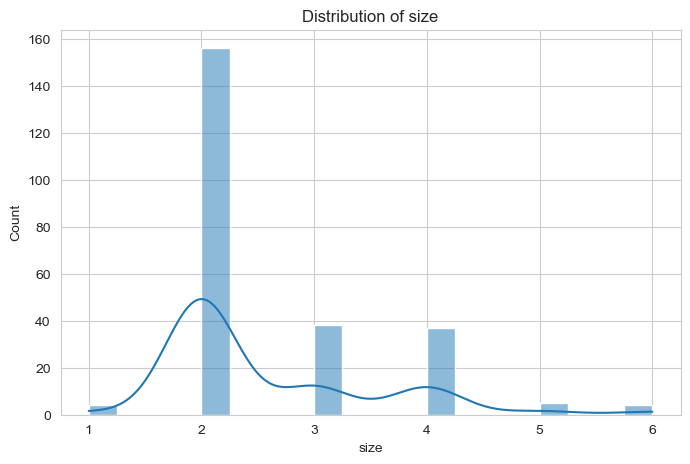

In [28]:
for col in num_cols:
    plt.figure()
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f"Distribution of {col}")
    plt.show()

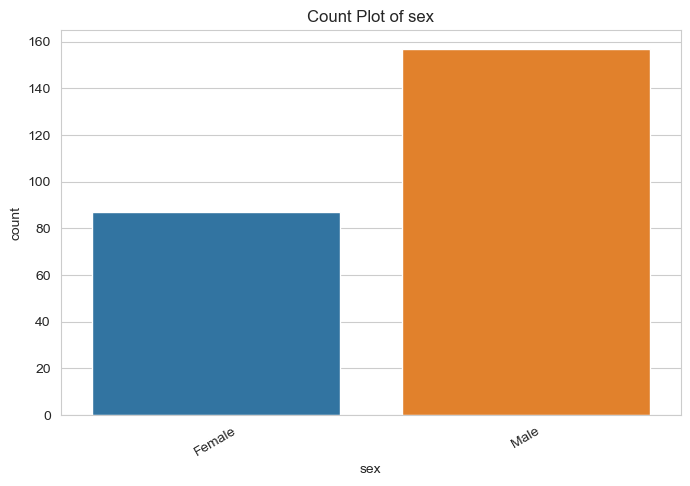

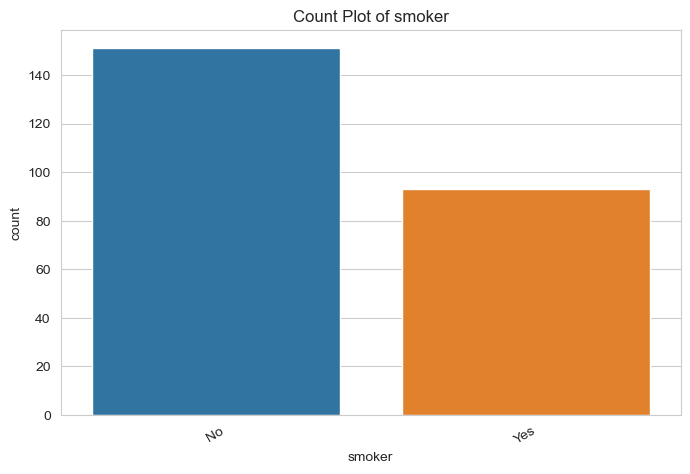

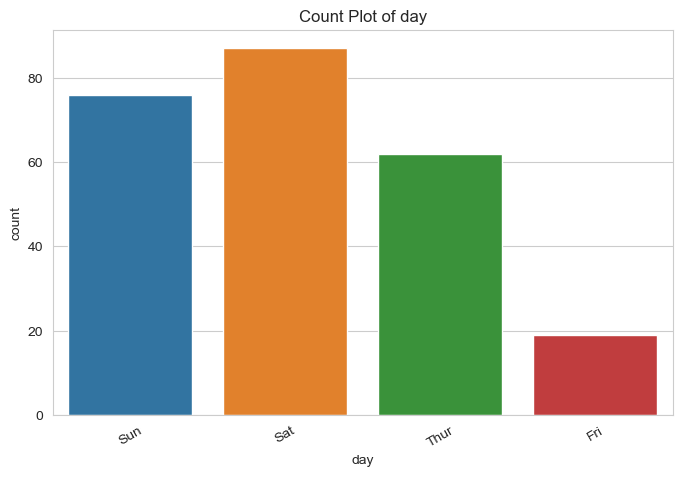

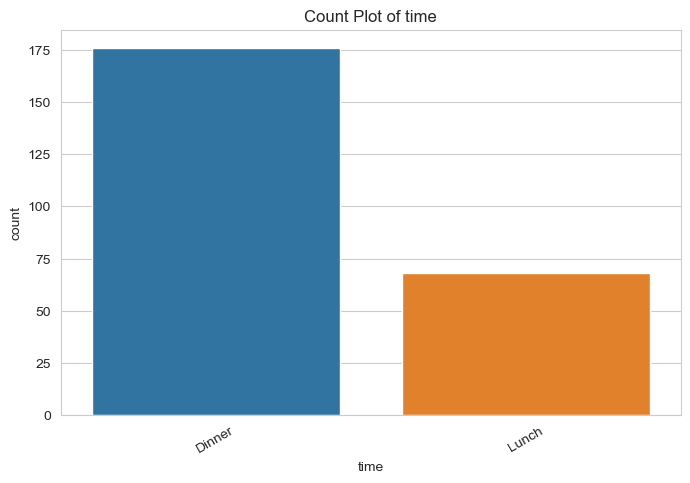

In [29]:
for col in cat_cols:
    plt.figure()
    sns.countplot(data=df, x=col)
    plt.title(f"Count Plot of {col}")
    plt.xticks(rotation=30)
    plt.show()

In [30]:
df['tip_percentage'] = (df['tip'] / df['total_bill']) * 100
df['is_smoker'] = df['smoker'].map({'Yes': 1, 'No': 0})
df['is_weekend'] = df['day'].isin(['Sat', 'Sun']).astype(int)

In [31]:
df = pd.get_dummies(df, columns=['sex', 'day', 'time'], drop_first=True)


In [32]:
df.drop(['smoker'], axis=1, inplace=True)


In [33]:
print("\n Feature Engineering Done. New columns:")
print(df.columns)


 Feature Engineering Done. New columns:
Index(['total_bill', 'tip', 'size', 'tip_percentage', 'is_smoker',
       'is_weekend', 'sex_Male', 'day_Sat', 'day_Sun', 'day_Thur',
       'time_Lunch'],
      dtype='object')


In [34]:
features = ['total_bill', 'tip', 'size', 'tip_percentage', 'is_smoker', 'is_weekend'] + \
           [col for col in df.columns if col.startswith(('sex_', 'day_', 'time_'))]
X = df[features]

In [35]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\n Data scaled successfully.")


 Data scaled successfully.


In [39]:
inertia = []
sil_scores = []
K = range(2, 11)

for k in K:
    model = KMeans(n_clusters=k, random_state=42, n_init='auto')  # ✅ added n_init
    model.fit(X_scaled)
    inertia.append(model.inertia_)
    sil_scores.append(silhouette_score(X_scaled, model.labels_))


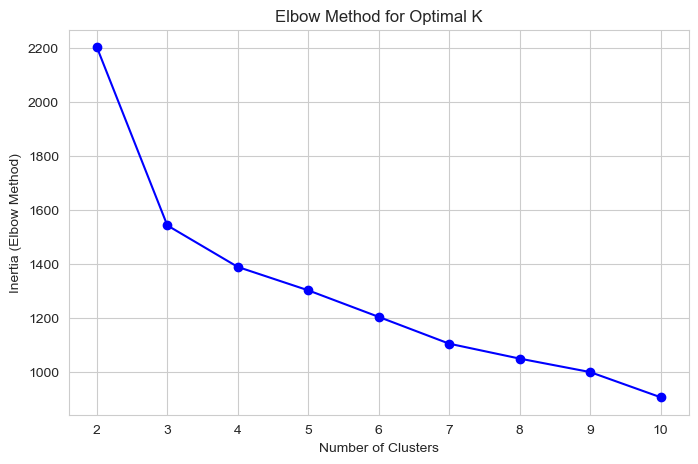

In [40]:
plt.figure()
plt.plot(K, inertia, 'bo-')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (Elbow Method)")
plt.title("Elbow Method for Optimal K")
plt.show()

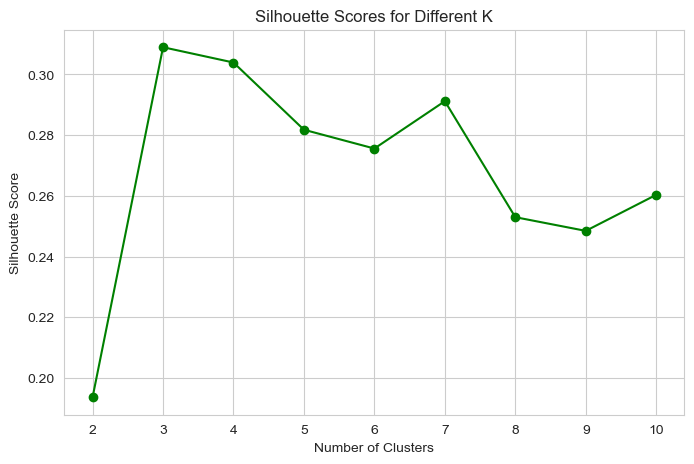

In [41]:
plt.figure()
plt.plot(K, sil_scores, 'go-')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Different K")
plt.show()

In [42]:
optimal_k = 3  # based on elbow and silhouette inspection
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

/Users/meghanas/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [44]:
print(f"\n Clustering done with K={optimal_k}")
print(df['cluster'].value_counts())


 Clustering done with K=3
0    93
2    76
1    75
Name: cluster, dtype: int64


In [45]:
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(X_scaled)
df['pca1'], df['pca2'] = pca_result[:, 0], pca_result[:, 1]

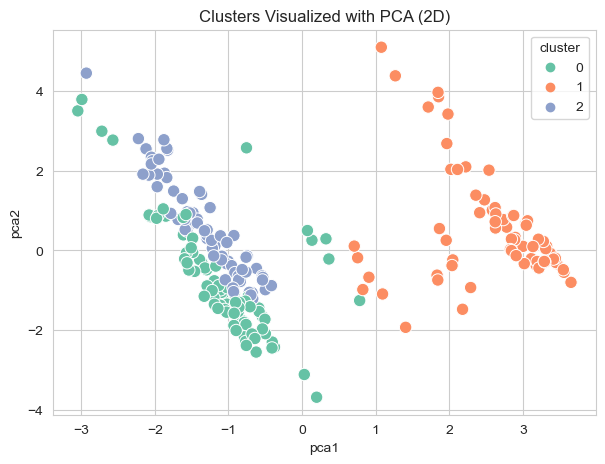

In [46]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x='pca1', y='pca2', hue='cluster', palette='Set2', s=80)
plt.title('Clusters Visualized with PCA (2D)')
plt.show()

In [47]:
print("\nExplained variance ratio (PCA):", pca.explained_variance_ratio_)



Explained variance ratio (PCA): [0.31310046 0.19082948]


In [48]:
# Show PCA loadings
pca_components = pd.DataFrame(pca.components_, columns=X.columns)
print("\nPCA Component Loadings:")
display(pca_components.T.head())


PCA Component Loadings:


,0,1
total_bill,-0.229594,0.506081
tip,-0.181557,0.495017
size,-0.180734,0.505740
tip_percentage,0.037603,-0.027120
is_smoker,-0.027448,-0.120593


In [49]:
sample_sil = silhouette_samples(X_scaled, df['cluster'])
df['silhouette'] = sample_sil

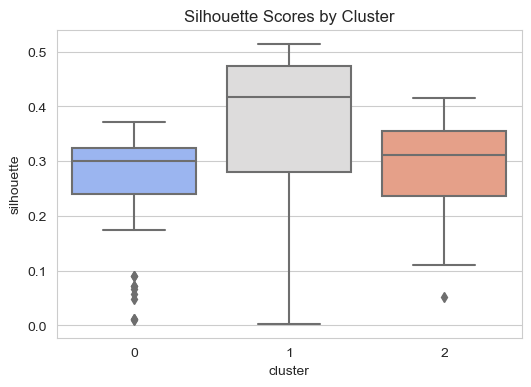

In [50]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='cluster', y='silhouette', data=df, palette='coolwarm')
plt.title('Silhouette Scores by Cluster')
plt.show()

In [51]:
summary = df.groupby('cluster')[['total_bill', 'tip', 'tip_percentage', 'size']].mean().round(2)
summary['count'] = df['cluster'].value_counts()
print("\nCluster Summary (Mean Values):")
display(summary)


Cluster Summary (Mean Values):


,total_bill,tip,tip_percentage,size,count
cluster,,,,,
0,20.76,3.01,15.18,2.51,93
1,16.94,2.72,16.58,2.37,75
2,21.41,3.26,16.69,2.84,76


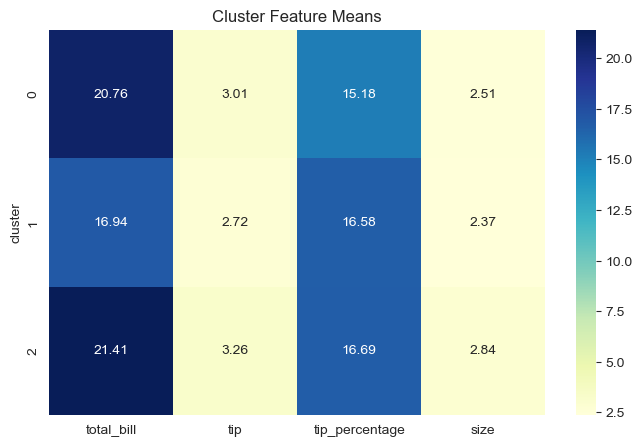

In [52]:
plt.figure(figsize=(8,5))
sns.heatmap(summary.drop(columns='count'), annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Cluster Feature Means')
plt.show()

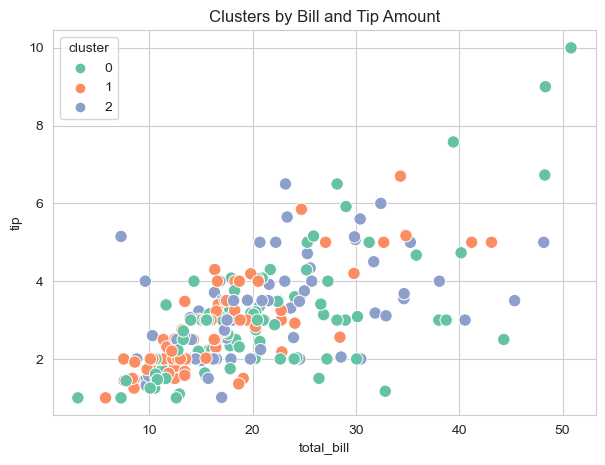

In [53]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x='total_bill', y='tip', hue='cluster', palette='Set2', s=80)
plt.title('Clusters by Bill and Tip Amount')
plt.show()